<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/3.2%20SNR%20Expectation%20Value%20Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import numpy as np
import pylab

import astropy.units as u
import matplotlib.pyplot as plt

from pycbc.waveform import get_td_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

In [ ]:
## Taken from notebook 3.1 (updated redshift and duration)

def create_waveform(mass1, mass2, resolution, frequencybound, distance, cosmology=Planck18):

  redshift = 1 + z_at_value(cosmology.comoving_distance, distance * u.Mpc)
  
  fbound = frequencybound * redshift

  waveform, waveform_cross = get_td_waveform(approximant="SEOBNRv4_opt",
                                             mass1=mass1,
                                             mass2=mass2,
                                             delta_t=resolution/redshift,
                                             f_lower=fbound)
  
  waveform_amplitude = [0.0] * len(waveform)
  waveform_time = [0.0] * len(waveform)

  for i in range(len(waveform)):
    waveform_amplitude[i] = waveform[i]
    waveform_time[i] = waveform.sample_times[i]

  waveform_amplitude = [i/distance for i in waveform_amplitude]
  waveform_time = [i*redshift for i in waveform_time]

  waveform_amplitude = np.array(waveform_amplitude)
  waveform_time = np.array(waveform_time)

  return waveform_amplitude, waveform_time

In [ ]:
## Create a GW Signal

## Resolution of signal = 4096 Hz
## Frequency resolution = 16 Hz
## Lower frequency bound = 20 Hz

gwamp, gwtime = create_waveform(mass1=30, mass2=30, resolution=1.0/4096, frequencybound=20, distance=100)
gwsignal = TimeSeries(gwamp, delta_t=1.0/4096)

gwsignalfreq = gwsignal.to_frequencyseries(delta_f = 1.0/16)

(20, 2048.0)

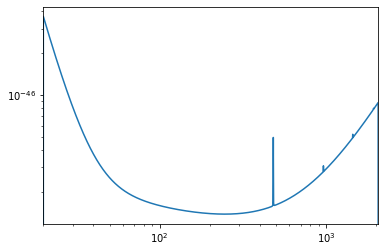

In [ ]:
## Choose a PSD template

flow = 20
delta_f = 1.0 / 16
flen = int(4096 / (2 * delta_f)) + 1

psd = pycbc.psd.aLIGODesignSensitivityP1200087(flen, delta_f, flow)

pylab.loglog(psd.sample_frequencies, psd)
pylab.xlim(flow, 4096/2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


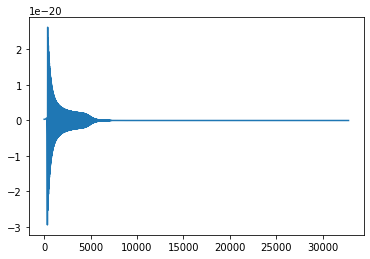

In [ ]:
## Create a template

template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=30, mass2=30, delta_t=1.0/4096, f_lower=20)
templatefreq = template.to_frequencyseries(delta_f=1.0/16)

pylab.plot(templatefreq)

In [ ]:
## Calculate the SNR

gwdata = gwsignalfreq + psd

snr = matched_filter(template=templatefreq, data=gwdata, psd=psd, low_frequency_cutoff=20)

print(max(abs(snr)))

346.474083820019


In [ ]:
def expectation_SNR(mass1, mass2, templatemass1, templatemass2, resolution, psdresolution, lowfreq, distance, psd, cosmology=Planck18):

  ## Create waveform 

  gwamp, gwtime = create_waveform(mass1=mass1, mass2=mass2, resolution=resolution, frequencybound=lowfreq, distance=distance, cosmology=cosmology)
  gwsignal = TimeSeries(gwamp, delta_t=resolution)
  gwsignalfreq = gwsignal.to_frequencyseries(delta_f = psdresolution)


  ## Create PSD 

  flen = int((1 / resolution) / (2 * psdresolution)) + 1

  if psd == 'aLIGOAPlusDesignSensitivityT1800042':
    psdfreq = pycbc.psd.aLIGOAPlusDesignSensitivityT1800042(flen, psdresolution, lowfreq)
  
  if psd == 'aLIGODesignSensitivityP1200087':
    psdfreq = pycbc.psd.aLIGODesignSensitivityP1200087(flen, psdresolution, lowfreq)

  if psd == 'CosmicExplorerP1600143':
    psdfreq = pycbc.psd.CosmicExplorerP1600143(flen, psdresolution, lowfreq)


  ## Create template

  template, _ = get_td_waveform(approximant="SEOBNRv4_opt", mass1=templatemass1, mass2=templatemass2, delta_t=resolution, f_lower=lowfreq)
  templatefreq = template.to_frequencyseries(delta_f = psdresolution)


  ## Calculate SNR

  gwdata = gwsignalfreq + psdfreq
  snr = matched_filter(template=templatefreq, data=gwdata, psd=psdfreq, low_frequency_cutoff=lowfreq)

  print("The signal-to-noise ratio is: {}".format(max(abs(snr))))

  return(max(abs(snr)))

In [ ]:
distances = np.arange(50, 1000, 50)
snr30 = [0] * len(distances)

for i in range(len(snr30)):
  snr30[i] = expectation_SNR(mass1=30, mass2=30, templatemass1=30, templatemass2=30, resolution=1.0/2048, psdresolution=1.0/16, lowfreq=20, distance=distances[i], psd='aLIGODesignSensitivityP1200087')

The signal-to-noise ratio is: 723.4278415940181
The signal-to-noise ratio is: 346.45773095430235
The signal-to-noise ratio is: 214.98297463891893
The signal-to-noise ratio is: 149.5167068523878
The signal-to-noise ratio is: 111.35581183868456
The signal-to-noise ratio is: 87.15569164131708
The signal-to-noise ratio is: 71.95618178884268
The signal-to-noise ratio is: 61.404309194938186
The signal-to-noise ratio is: 53.80761883992265
The signal-to-noise ratio is: 47.37593593525607
The signal-to-noise ratio is: 41.99187190757474
The signal-to-noise ratio is: 37.23051617925417
The signal-to-noise ratio is: 33.39606701749905
The signal-to-noise ratio is: 30.064908898153686
The signal-to-noise ratio is: 27.30691901810005
The signal-to-noise ratio is: 25.118213839766334
The signal-to-noise ratio is: 23.355606006161015
The signal-to-noise ratio is: 21.82549010961944
The signal-to-noise ratio is: 20.53490111818488


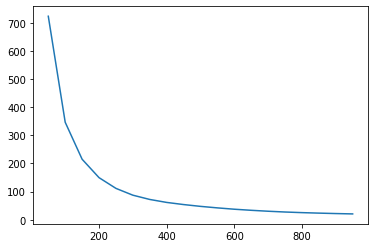

In [ ]:
pylab.plot(distances, snr30)